# Obtain important patterns per nawba using SIA algorithm
Notebook to carry experiment of the master thesis. This is based on applying SIA algorithm to the whole Arab-Andalusian symbolic dataset and in the end, obtain a list of relevant patterns per nawba. Finally, results are evaluated through two different kind of techniques: a logistic classifier using pattern occurrences, logistic regression model using pattern features.

In [6]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
import sys

import glob
import json
from collections import Counter
import csv
from music21 import*
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


sys.path.append('../src/')
import patterns_per_nawba as pn
import nawba_centones
import classification as cl
import symbolic_features
import all_scores_features

data_path = '../data'

## Loading of data
In order to deal with the experiment we need to download and parse the data related to nawba, tab and centos with the corresponding mbids ot each score.

In [2]:
# nawba mappings to centones
nawba_centones_lookup = nawba_centones.load_and_parse_centones_mapping(os.path.join(data_path, 'centones_nawba.csv'))

# list of scores to parse
andalusian_description =  pd.read_json(os.path.join(data_path, 'andalusian_description.json'))

# mbid mappings to nawbas
nawba_tabs = nawba_centones.load_and_parse_nawba_tabs(os.path.join(data_path, 'nawba_tabs.json'))
mbid_tab_lookup = pn.mbids_per_tab(andalusian_description)
mbid_nawba_lookup = pn.mbids_per_nawba(mbid_tab_lookup, nawba_tabs)
    


## SIA algorithm
The next step go through each output of the SIA algorithm for each score stored in 'results/' . After this, output patterns are filtered by length of minimum 3 and maximum 10 events (notes and rest) and put together with the patterns from the same nawba. Finally, just the 10 patterns with most occurrences are taken by nawba, generating a list of patterns per nawba with 10 items and converted to MIDI format. 

(Time of execution of next cell might take more than an hour depending of the machine. We advice to run the following one to load the data immediately from a JSON file)

In [ ]:
path='../results/SIA_09005/chroma'
print("Getting patterns...")
nawba_patterns_lookup = pn.parse_SIA_patterns(path, mbid_nawba_lookup)
                        
print("Cleaning unimportant patterns...")
# get 10 most common patterns for the obtained results per nawba:
nawba_patterns_lookup = pn.conv_pattern_list_to_string(nawba_patterns_lookup)
nawba_patterns_lookup = pn.get_repeated_patterns_and_conv_to_wav(nawba_patterns_lookup)

In [5]:
with open('../results/nawba_patterns_lookup.json') as json_file:
    nawba_patterns_lookup = json.load(json_file)

## Results
See the variability of the results and compare with the centos

In [6]:
# Let's check how many of our patterns are similar to the centos of the required nawba
total_centos = 0
total_patterns = 0
for nawba in nawba_patterns_lookup:
    if nawba != 'none':
        for cento in nawba_centones_lookup[nawba]:
            for pattern in nawba_patterns_lookup[nawba]:
                if cento in pattern:
                    total_centos += 1
    total_patterns += len(nawba_patterns_lookup[nawba])
print("{}% of our discovered patterns contains centos".format(round(total_centos*100/total_patterns, 2)))

54.55% of our discovered patterns contains centos


In [7]:
# Let's check how many of our patterns contains centos from the corresponding nawba
total_centos = 0
total_patterns = 0
for nawba in nawba_patterns_lookup:
    if nawba != 'none':
        with open('../results/patterns_midi/similarity/similarity_coefficients/sia' + str(nawba) + '-centos' + str(nawba) + '.csv') as csv_file:
            sia_patterns = [row[0] for row in csv.reader(csv_file, delimiter=',') if row[0] != "query_pattern"]
            for pattern in nawba_patterns_lookup[nawba]:
                if pattern in sia_patterns:
                    total_centos += 1
    total_patterns += len(nawba_patterns_lookup[nawba])
print("{}% of our discovered patterns are similar to the centos".format(round(total_centos*100/total_patterns, 2)))

42.73% of our discovered patterns are similar to the centos


## Evaluation with Logistic regression using number of pattern occurrences in score

In order to construct our nawba classifier we compute all the possible patterns of length 3 - 10 from all the scores in our dataset.

In [3]:
scores_path = '../data/scores_xml/'
notes_dict = cl.get_notes_from_score(scores_path, mbid_nawba_lookup)
mbid_patterns =cl.get_bag_of_patterns(notes_dict)

2d8e2820-e4cf-4dc8-b4f1-45f8fb65de9e contains chords and wont be counted


An l2 regularised logistic regression model is applied to our corpus of 149 scores, we use a 60/40 train/test. As features for our classifier, we will take the number of occurrences of each of our 10 top patterns per nawba

In [6]:
data = []
for idx, mbid in enumerate(notes_dict.keys()):
    data.append([[], []])
    data[idx][0] = mbid
    for patterns in nawba_patterns_lookup.values():
        for pattern in patterns:
            data[idx][1].append(notes_dict[mbid].count(pattern))

We bootstrap our accuracy score on test 100 times

In [7]:
results = [cl.train_classifier(data, mbid_nawba_lookup, plotMatrix=False) for x in range(100)]

In [8]:
print('Results: {} ({})'.format(round(np.mean(results)*100, 2), round(np.std(results)*100,2)))


Results: 65.42 (5.91)


## Evaluation with Logistic regression using pattern features
Let's classify the nawba using features from the output SIA patterns of each score

In [61]:
midi_pattern_features = all_scores_features.get_output_SIA_features()

with open('../results/result_score_features.json') as outfile:
    mbid_pattern_occurrence_dict = json.load(outfile)
X, Y = all_scores_features.compute_X_Y_model(mbid_pattern_occurrence_dict, midi_pattern_features)

In [16]:
results = [all_scores_features.train_classifier_features(X, Y)[0] for x in range(100)]

In [17]:
print('Results: {} ({})'.format(round(np.mean(results)*100, 2), round(np.std(results)*100,2)))


Results: 29.69 (5.4)


In [18]:
importance = np.mean([all_scores_features.train_classifier_features(X, Y)[1] for x in range(100)], axis=0)

<BarContainer object of 23 artists>

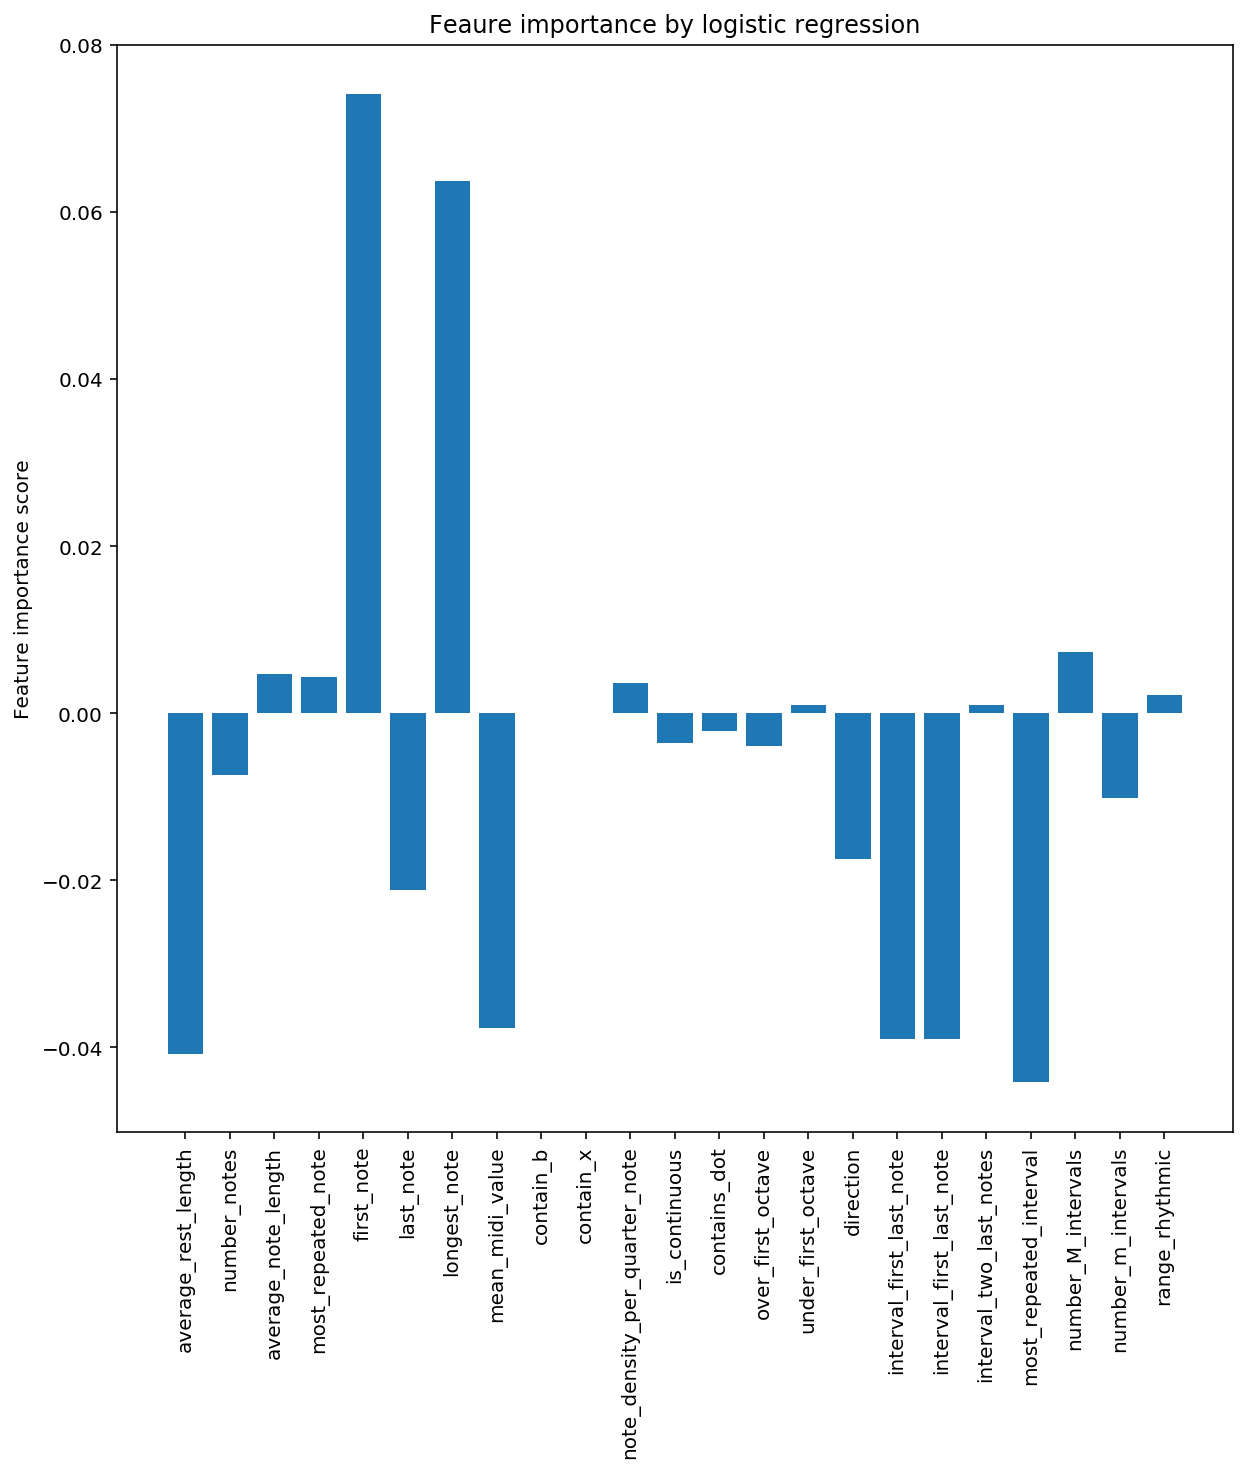

In [19]:
feature_names = ['average_rest_length',
    'number_notes',
    'average_note_length',
    'most_repeated_note',
    'first_note',
    'last_note',
    'longest_note',
    'mean_midi_value',
    'contain_b',
    'contain_x',
    'note_density_per_quarter_note',
    'is_continuous',
    'contains_dot',
    'over_first_octave',
    'under_first_octave',
    'direction',
    'interval_first_last_note',
    'interval_first_last_note',
    'interval_two_last_notes',
    'most_repeated_interval',
    'number_M_intervals',
    'number_m_intervals',
    'range_rhythmic']

# plot feature importance
plt.figure(figsize=(10,10))
plt.title('Feaure importance by logistic regression')
plt.xticks(range(len(feature_names)),feature_names,rotation=90)
plt.ylabel('Feature importance score')
plt.bar([x for x in range(len(importance))], importance)

## Evaluation with logistic regression using occurrences + selected symbolic features


Finally let's build a classifer using pattern occurrences and a subset of the symbolic pattern features selected under Amin's criteria

In [98]:
X_mix = X
for ocurr in data:
    mbid = ocurr[0]
    if mbid in X_mix:
        X_mix[mbid] = np.concatenate((ocurr[1], [X_mix[mbid][3]], [X_mix[mbid][4]], [X_mix[mbid][5]], [X_mix[mbid][6]], [X_mix[mbid][7]], [X_mix[mbid][8]], [X_mix[mbid][9]]))
        
Y_mix = [mbid_nawba_lookup[mbid] for mbid in X_mix]

In [81]:
len(X_mix[mbid])

117

In [99]:
results = [all_scores_features.train_classifier_features(X_mix, Y_mix)[0] for x in range(100)]

In [100]:
print('Results: {} ({})'.format(round(np.mean(results)*100, 2), round(np.std(results)*100,2)))

Results: 70.14 (6.64)
